In [48]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #03 - Statistical Objective Analysis

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using statistical objective analysis.
#1 Step: We needed to caluclate a singluar background field that would be applied to all analyses (N = 2,4,10). This was done using the Barnes function and the single ROI value of 
12.7775892. This will be our background matrix.
#2 Step: We will be doing the forward interpolation. This got us the background observation values at the observation stations. This used bilinear for the points within the grid
and the barnes was used for the points that were not within the grid.
#3 Step: A statistical objective analysis scheme for N = 2, 4, 10 which means we were pulling the closest 2 obs, 4 obs, and 10 obs. The correlation calculates the a-posteriori weights.
#4 Step: Find the analysis increments, RMS, and the Analysis difference for each SOA.
"""

__author__    = "Talia D. Kurtz"
__contact__   = "talia.kurtz@und.edu"

In [49]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import csv
import pandas as pd

In [50]:
### Read in observations ###
file = open('C://Users/research/thesis_code/ATSC_528_09192022/ATSC528_2022-main/01-Function_Fitting/RAOBs_201903131200.txt')
csvreader = csv.reader(file)
###########################################################################################################################
rows = []
for row in csvreader:
        rows.append(row)
rows #Reading in the data this way because there are no headers and there are /n 

[['CWPL', '51.47', '-90.20', '5460.0', '285.0', '29.0'],
 ['CWQI', '43.83', '-66.00', '5540.0', '325.0', '41.0'],
 ['CWSE', '53.55', '-113.90', '5360.0', '280.0', '12.0'],
 ['CYAH', '53.75', '-73.60', '5340.0', '300.0', '70.0'],
 ['CYBK', '64.30', '-96.00', '5220.0', '95.0', '17.0'],
 ['CYCB', '69.10', '-105.10', '5190.0', '245.0', '32.0'],
 ['CYEU', '80.00', '-85.80', '4890.0', '200.0', '40.0'],
 ['CYEV', '68.30', '-133.40', '5210.0', '245.0', '37.0'],
 ['CYFB', '63.75', '-68.50', '5140.0', '290.0', '17.0'],
 ['CYJT', '48.53', '-58.50', '5360.0', '280.0', '45.0'],
 ['CYLT', '82.52', '-62.20', '4970.0', '255.0', '21.0'],
 ['CYMO', '51.27', '-80.60', '5450.0', '275.0', '37.0'],
 ['CYPH', '58.47', '-78.00', '5180.0', '285.0', '25.0'],
 ['CYQD', '53.97', '-101.10', '5370.0', '250.0', '31.0'],
 ['CYRB', '74.72', '-94.90', '5020.0', '250.0', '72.0'],
 ['CYSA', '43.93', '-60.00', '5490.0', '300.0', '21.0'],
 ['CYSM', '60.02', '-111.90', '5230.0', '300.0', '32.0'],
 ['CYUX', '68.78', '-81.20'

In [51]:
list_name = rows
df = pd.DataFrame (list_name, columns= ['Station ID', 'Lat', 'Lon', '500 mb Height', '500mb Wind Dir', '500mb Wind Speed'])
obs_lon = df['Lon'].astype(float)   #Getting the values to be floats.
obs_lat = df['Lat'].astype(float) #Getting the values to be floats.
obs_lon_rads = obs_lon*(np.pi/180)   #Getting from degrees to radians 
obs_lat_rads = obs_lat*(np.pi/180)  #Getting from degrees to radians
height = df['500 mb Height'].astype(float)  #Getting the values to be floats.
fobs = np.array(height)  #Pandas made it a series so we need to get it back into an array
#print(fobs)

In [52]:
### Set up analysis map with a 22x28 rectangular grid of points ###
x = 18.9 #x_o (NW corner of map i.e. the (0,0) array memember)
y = -6.3 #y_o (NW corner of map i.e. the (0,0) array memember)
delta_x = 1.27
delta_y = 1.27 #spacing of our points 
######################################################################
#Making the points on the map. Analysis points 
x_step = x + np.arange(22)*delta_x
y_step = y + np.arange(28)*delta_y

grid_x, grid_y = np.meshgrid(x_step,y_step)

In [53]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###
#Longitude (from grid to longitude)
map_proj = 1/(15e6)
rho = 6371 * 1e5 #radius of Earth
lambda_o = -115
phi_o = 60*(np.pi/180)   #Converting to radians
phi_4 = 40*(np.pi/180) 

phi_eq = ((1 +np.sin(phi_o))/(1+np.sin(phi_4)))
print(phi_eq)
map_give = 1.24
#We are converting from the distance on the map to the distance on the earth
map_new_val = map_give/phi_eq
print(map_new_val)

#We are converting it from cm to longitude and latitude so that we can plot it 
##############################################################################
#converting the longitude from x-values to longitude  
proj_lon = np.arctan(grid_y/grid_x)*(180/np.pi) + lambda_o    #The projection in python has to be in latitude and longitude so these two steps are to go to lat/lon for the projection
#Converting the y-values to latitude values
proj_lat = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((grid_x/map_proj)**2+(grid_y/map_proj)**2)/(rho*(1+np.sin(phi_o)))))) 

1.135889626134017
1.0916553611113793


[ 11.61916975  25.49496762   0.50098563  17.15657251   5.8860582
   2.51321867   3.38283323  -4.79491228  13.40490509  25.01975003
   4.12669525  15.73780472  13.46560816   6.19184917   3.65357421
  27.60498527   1.14765199   8.25917343  16.45804351  -3.55161272
  -2.88546379   7.94359987  21.41578639  -6.03205367  21.57530372
  -3.50531973   6.02070753   9.274871   -13.91718457  21.081725
 -14.751282     7.52847747  23.5544805    9.44498019 -11.68471711
  -7.0909007   17.65677663  15.86539192 -15.06012504   7.75670783
  21.13311393  19.15334909  -0.7119138   15.00391671  -8.68108918
  20.43582839  17.14158101  22.90878124 -18.37053172  25.16886977
  24.73391592  14.38539636  10.12138229   6.62923169  11.44630281
   3.2062888    6.57750142  11.28948315  18.18683372  14.76414795
   6.35890641  27.96200732  -9.58897357  21.67285223   2.29182183
  12.57089829  13.57104305   4.41889421   4.26697047  15.04399666
  23.18043977  23.7437395   23.09142179  19.39436552  16.3766252
  11.08211695 

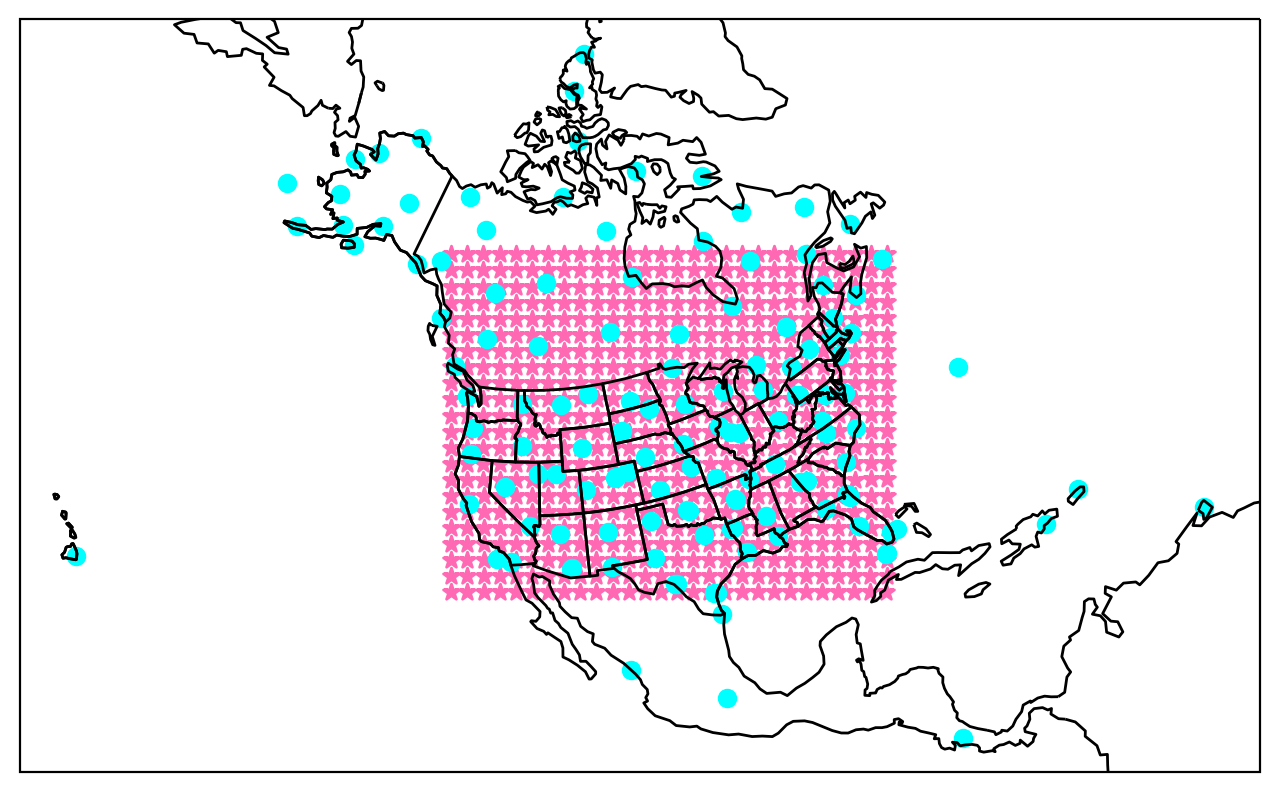

In [54]:
#convert the latitude and longitude form the text file and put them in the (x,y) form
#Trying to find sigma (image scale factor)
# sigma = (1 +sine (phi_o))/(1+sine(phi)) where phi is the latitude
phi_o = 60*(np.pi/180)


sigma_obs = (1 + np.sin(phi_o))/(1+np.sin(obs_lat_rads)) #this is our image scale factor
#print(sigma_obs)

#Determine the radius of any latitude circle 
lat_circle_radius = rho * sigma_obs*(np.cos(obs_lat_rads)) #this is the little r 
#print(lat_circle_radius)

#Solve for lambda which is the deviation of longitude from the standard longitude ( longitude of a point - lambda_o)
lambda_obs = ((obs_lon_rads)-(lambda_o*(np.pi/180)))
#print(lambda_obs)

#Now we are solving the observations for x 
x_obs = rho*sigma_obs*(np.cos(obs_lat_rads))*(np.cos(lambda_obs)) *map_proj 
#Now we are solving the observations for y 
y_obs = rho*sigma_obs*(np.cos(obs_lat_rads))*(np.sin(lambda_obs))* map_proj

x_obs = np.array(x_obs)
y_obs = np.array(y_obs)
print(y_obs)
#print(x_obs)
#print(y_obs)

obs_lon = np.arctan(y_obs/x_obs)*(180/np.pi) + lambda_o

#Converting the y-values to latitude values
obs_lat = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x_obs/map_proj)**2+(y_obs/map_proj)**2)/(rho*(1+np.sin(phi_o)))))) 
#x,y coords for our observations 


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

ax1.scatter(proj_lon, proj_lat,transform=ccrs.PlateCarree(), marker ="*", color = 'hotpink')
ax1.scatter(obs_lon, obs_lat, transform=ccrs.PlateCarree(), color = "cyan")

In [55]:
#We need to do the Barnes Analysis of the Observation Values
### Create function for Cressman Analysis ###

#We are defining the radius of influence and hard coding the value.

#Barnes is in the grid, and this is for the background for the analysis locations. 
def barnes(dik, R):
    if(dik<= R):
        Kd = 10.8844524
        weight = np.exp((-dik**2)/Kd)
    elif(dik > R):
        weight = 0
    else:
        print("You have really goofed up")
    return weight


# z1 is now (0,0)
# z2 is now (1,0)
# z3 is now (0,1)
# z4 is now (1,1)
# x2, y2 is now just 1
# x1, y1 are now zero
def bilinear(x,y):
    rel_x = x -int(np.floor(x)) # in the equation this is the normal x
    rel_y = y - int(np.floor(y)) #in the equation this is the normal y
    z1 = background_matrix[int(np.floor(y)), int(np.floor(x))] #Here what we need to think about is that point in the middle and rounding down and up the index to get them to zeros and ones.
    z2 = background_matrix[int(np.ceil(y)), int(np.floor(x))] #We are doing things in terms of the index
    z3 = background_matrix[int(np.ceil(y)), int(np.ceil(x))]
    z4 = background_matrix[int(np.floor(y)), int(np.ceil(x))]
    
    p =(((rel_x-1)*(rel_y-1)*z1) - ((rel_x)*(rel_y-1)*z2) + (((rel_x)*(rel_y))*z3) - ((rel_x-1)*(rel_y)*z4))
    return p

def bilinear2(x,y, N):
    rel_x = x -int(np.floor(x)) # in the equation this is the normal x
    rel_y = y - int(np.floor(y)) #in the equation this is the normal y
    z1 = analysis_matrix[int(np.floor(y)), int(np.floor(x)), N] #Here what we need to think about is that point in the middle and rounding down and up the index to get them to zeros and ones.
    z2 = analysis_matrix[int(np.ceil(y)), int(np.floor(x)), N] #We are doing things in terms of the index
    z3 = analysis_matrix[int(np.ceil(y)), int(np.ceil(x)), N]
    z4 = analysis_matrix[int(np.floor(y)), int(np.ceil(x)), N]
    
    p =(((rel_x-1)*(rel_y-1)*z1) - ((rel_x)*(rel_y-1)*z2) + (((rel_x)*(rel_y))*z3) - ((rel_x-1)*(rel_y)*z4))
    return p

#To use cartesian corrdinates we must convert so the -1.24 became -1.09
def correlation(dik):
    rho_dik = 0.95 * np.exp(-(map_new_val)*(dik**2))
    #correlation for distances less than 1km to equal 1. Gives you an array of true and falses. Trues get set to 1.
    rho_dik[dik < 1e-3] = 1
    return rho_dik

Text(0.5, 1.0, 'Background Pass')

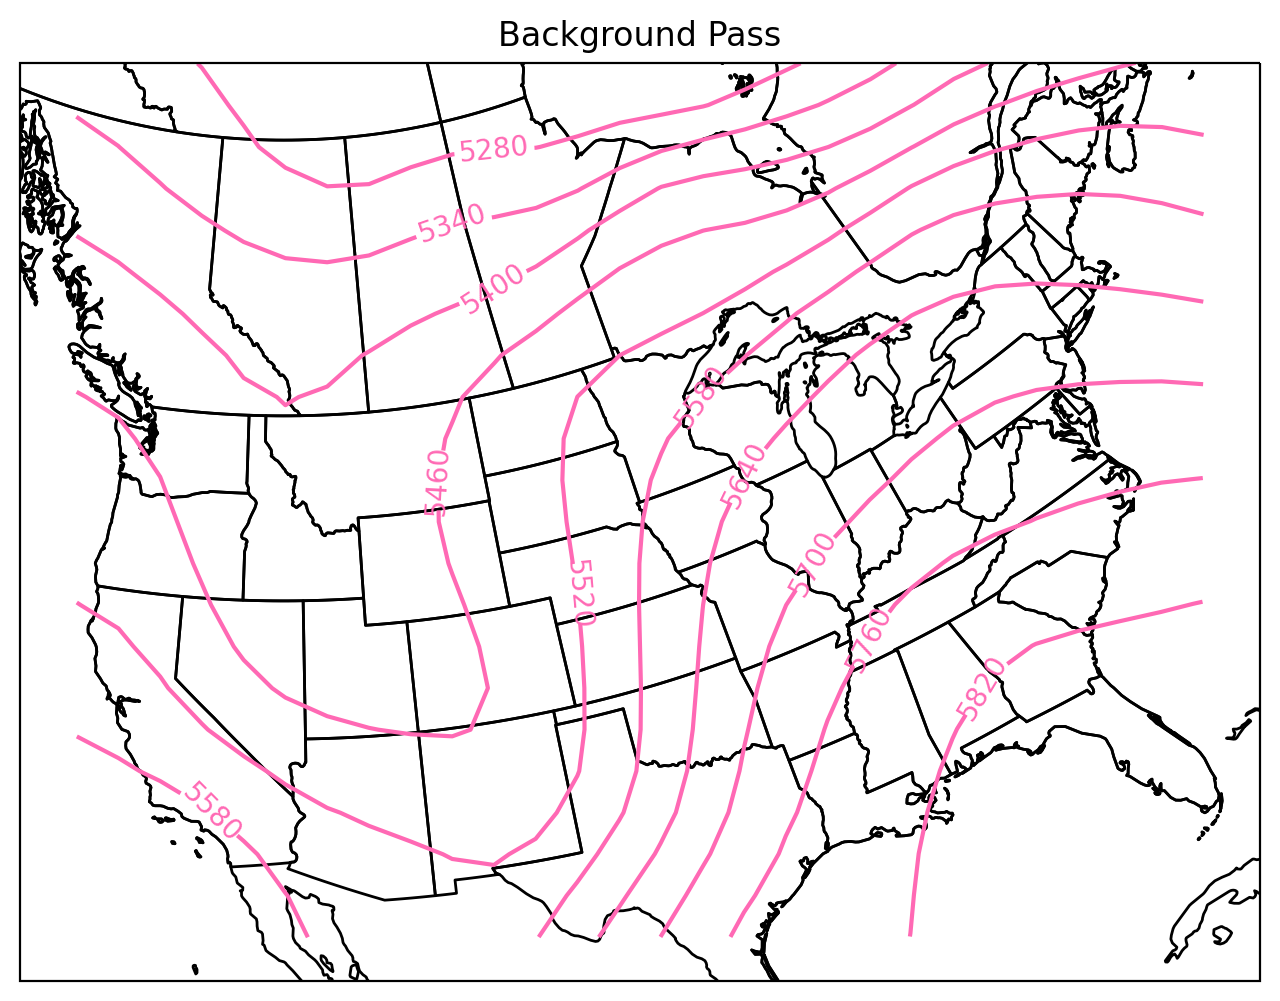

In [56]:
R1 = 12.7775892
Ro_vals = np.array([R1])


ROI_1 = Ro_vals[0]
y_cols = 28
x_cols = 22
#Make two empty arrays one for the observations and one for the Analysis 

background_matrix = np.empty((y_cols, x_cols))

for j in range(len(grid_x)):
    for k in range(len(grid_x[0])):
        x_rel = grid_x[j,k] - x_obs   #This is the distance in the x 
        y_rel = grid_y[j,k] - y_obs   #This is the distance in the y. 
            #This will the distance formula so we are getting the radius here remember the bubble with the points.
        radius = ((x_rel**2 + y_rel**2)**(1/2)) 
        index_ROI = np.where(radius <= ROI_1)[0]

        
        weights_matrix = np.zeros(len(x_obs))
        for i in index_ROI:
            w = barnes(radius[i], ROI_1)
            weights_matrix[i] = w
            
        background_matrix[j, k] = np.sum(weights_matrix * fobs) / np.sum(weights_matrix)

#Forward interpolation is when you are interpolating from the grid to the observation locations. You will be getting the background at the observation locations
#extrapolating is extraplolating outside of the grid. This is dangerous. 
### Plot 500mb analyses over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

  
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(proj_lon,proj_lat,background_matrix[:,:],colors='hotpink',levels = np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(0,8000,60))
plt.title("Background Pass")

In [57]:
#Forward Interpolation to get the values at the observation locations.
# the x coord of observations minus the x0 divided by the spacing of the points this will be the same for y
#it is for bilinear
index_x = ((x_obs - x)/delta_x)
index_y = ((y_obs - y)/delta_y)

ROI_1= Ro_vals[0]
#finding analysis values at the observation locations. We have the analysis value at the analysis location. 
bilinear_result = np.zeros(len(x_obs))   #
for i in range(len(index_x)):
    if (index_x[i]>= 0) and (index_x[i] < 21) and (index_y[i] >= 0) and (index_y[i] < 27):      #this is the ones that in our grid and we need to use the bilinear here
        p = bilinear(index_x[i], index_y[i])  #you are using the first index of the analysis matrix 
    else:
        x_dist_analysis = x_obs[i] - grid_x
        y_dist_analysis = y_obs[i] - grid_y
        radius_analysis = ((x_dist_analysis)**2 + (y_dist_analysis)**2)**(1/2)   #this is the distance formula
        vals_analysis = np.where(radius_analysis <= Ro_vals[0])    #is it in our ROI?
        weights_analysis = np.zeros(grid_x.shape)
   
        for j in vals_analysis[0]:  #for the outer points that aren't in the pink star grid. They still have (x,y)
            for k in vals_analysis[1]:
                weights_cressman_analysis = barnes(radius_analysis[j,k], Ro_vals[0])
                weights_analysis[j,k] = weights_cressman_analysis
        p = np.sum(weights_analysis*background_matrix[:,:])/np.sum(weights_analysis)   
    bilinear_result[i] = p
print(bilinear_result)

C:\Users\research\AppData\Local\Temp\ipykernel_8436\3767693695.py:24: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(weights_analysis*background_matrix[:,:])/np.sum(weights_analysis)


[5461.88050834 5538.24550379 5356.11734678 5330.0878094  5247.31672481
 5240.86232358           nan 5299.8007376  5259.95643923 5470.5629571
           nan 5456.45714116 5295.7884238  5378.02537342 5234.491013
 5491.52330485 5257.99100814 5237.86823889 5321.4441034  5295.76404417
 5329.59134772 5260.59802189 5416.31042967 5429.26441256 5456.61273623
 5388.30240214 5489.79496161 5542.0648065  5333.34943562 5704.81935078
 5327.39452476 5474.82512695 5644.78543997 5539.3110483  5325.66275762
 5381.78624932 5640.05623888 5765.79337407 5322.11506212 5507.89936286
 5808.84376373 5768.78719617 5418.64717119 5765.0686252  5311.85588504
 5670.8416495  5752.83737012 5527.71059297 5323.90057072 5623.98598525
 5800.74406057 5745.92437601 5541.04166056 5485.4117143  5678.3787066
 5537.63757244 5486.81252769 5676.32835474 5672.22094975 5660.92385526
 5533.12863045 5877.24108115 5318.5446014  5813.83091555 5512.83398739
 5611.46855505 5686.50770139 5451.73111009 5448.1703168  5631.76524869
 5766.3417

In [58]:
N = [2,4,10]
analysis_matrix = np.empty((y_cols, x_cols, len(N)))

for n in range(len(N)):
    num_points = N[n]
    for i in range(len(grid_x)):
        for j in range(len(grid_x[i])):
            r = ((grid_x[i,j]-x_obs)**2+(grid_y[i,j]-y_obs)**2)**(1/2)
            new_r = r*(0.15)
            sorted_index = np.argsort(new_r)
            this_xobs = x_obs[sorted_index[:num_points]]
            this_yobs = y_obs[sorted_index[:num_points]]
            this_dist = new_r[sorted_index[:num_points]]
            #print(this_dist)
            this_heights = fobs[sorted_index[:num_points]]
            this_bilinear = bilinear_result[sorted_index[:num_points]]
            #we must calculate the distance between the obs and obs.
            correlation_array = np.empty((num_points,num_points))
            correlation_grid_obs = np.empty((num_points,num_points))
    
            for k in range(len(this_xobs)):
                #distance between observations and observations
                dik = ((this_xobs[k]-this_xobs)**2+(this_yobs[k]-this_yobs)**2)**(1/2)
                
                #the correlation gives us the a-posteriori weights
                correlation_array[k] = correlation(dik*0.15)
           # print(correlation_array)
            #this is the distance between the analysis points and obs
            correlation_grid_obs = np.matrix(correlation(this_dist)).T
            #print(correlation_grid_obs)
            #.flatten is doing a multiplication and makes it so that we aren't doing a (2,1) and converts it to a (2)
            weights = np.array(np.linalg.inv(correlation_array)*(correlation_grid_obs)).flatten()
            #time to do the analysis equation
            analysis_matrix[i,j,n] = background_matrix[i,j] + np.nansum(weights*(this_heights-this_bilinear))
print(analysis_matrix.shape)
        

(28, 22, 3)


Text(0.5, 1.0, 'N= 2 Map')

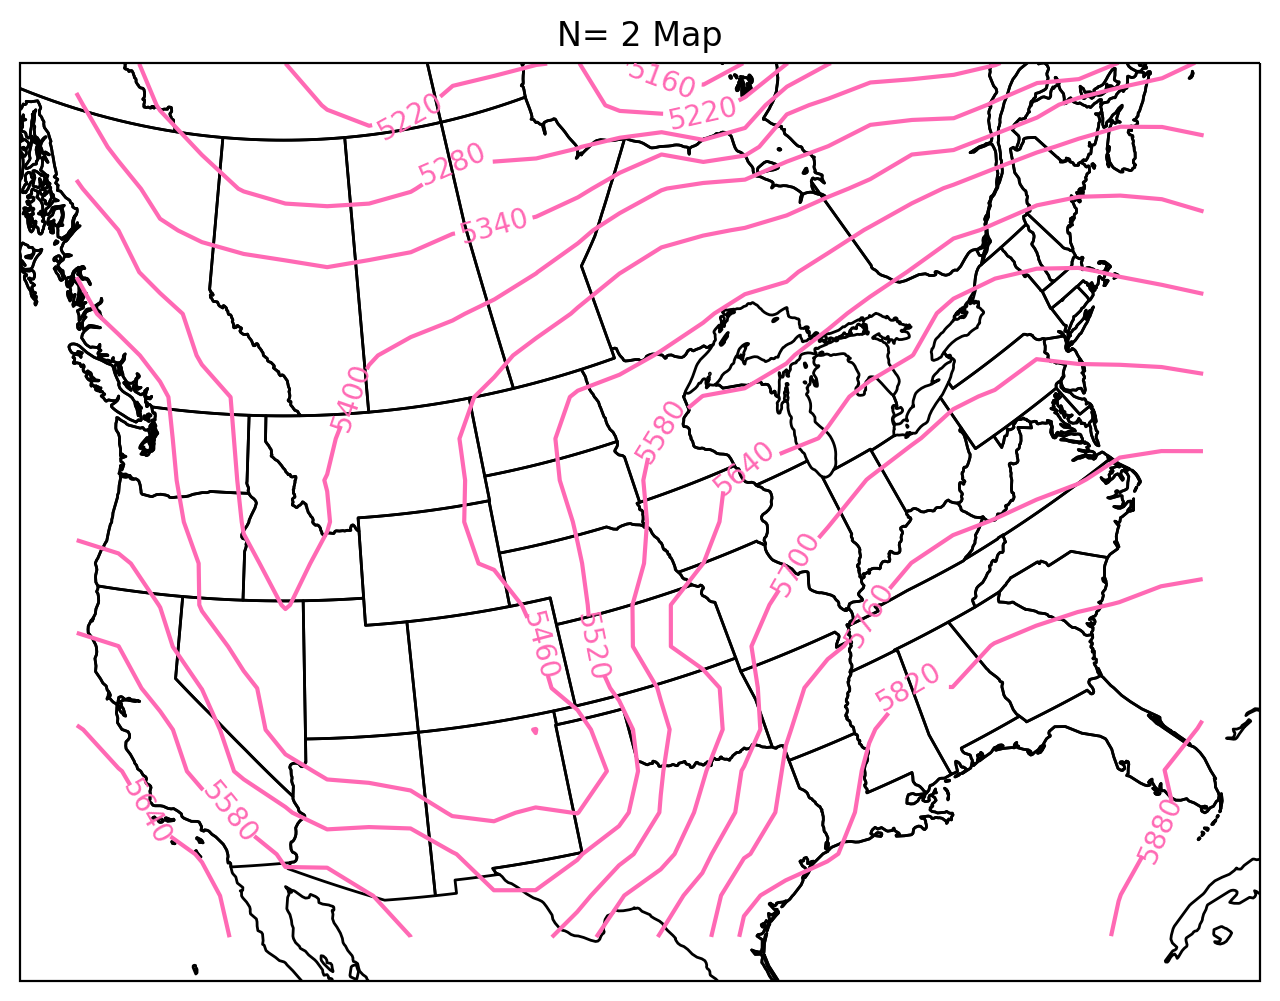

In [59]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

  
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(proj_lon,proj_lat,analysis_matrix[:,:,0],colors='hotpink',levels = np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(0,8000,60))
plt.title("N= 2 Map")

plt.savefig('C://Users/research/thesis_code/ATSC_528_09192022/ATSC528_2022-main/03-Statistical_Objective_Analysis/Map_analysis_N_2.png')

Text(0.5, 1.0, 'N= 4 Map')

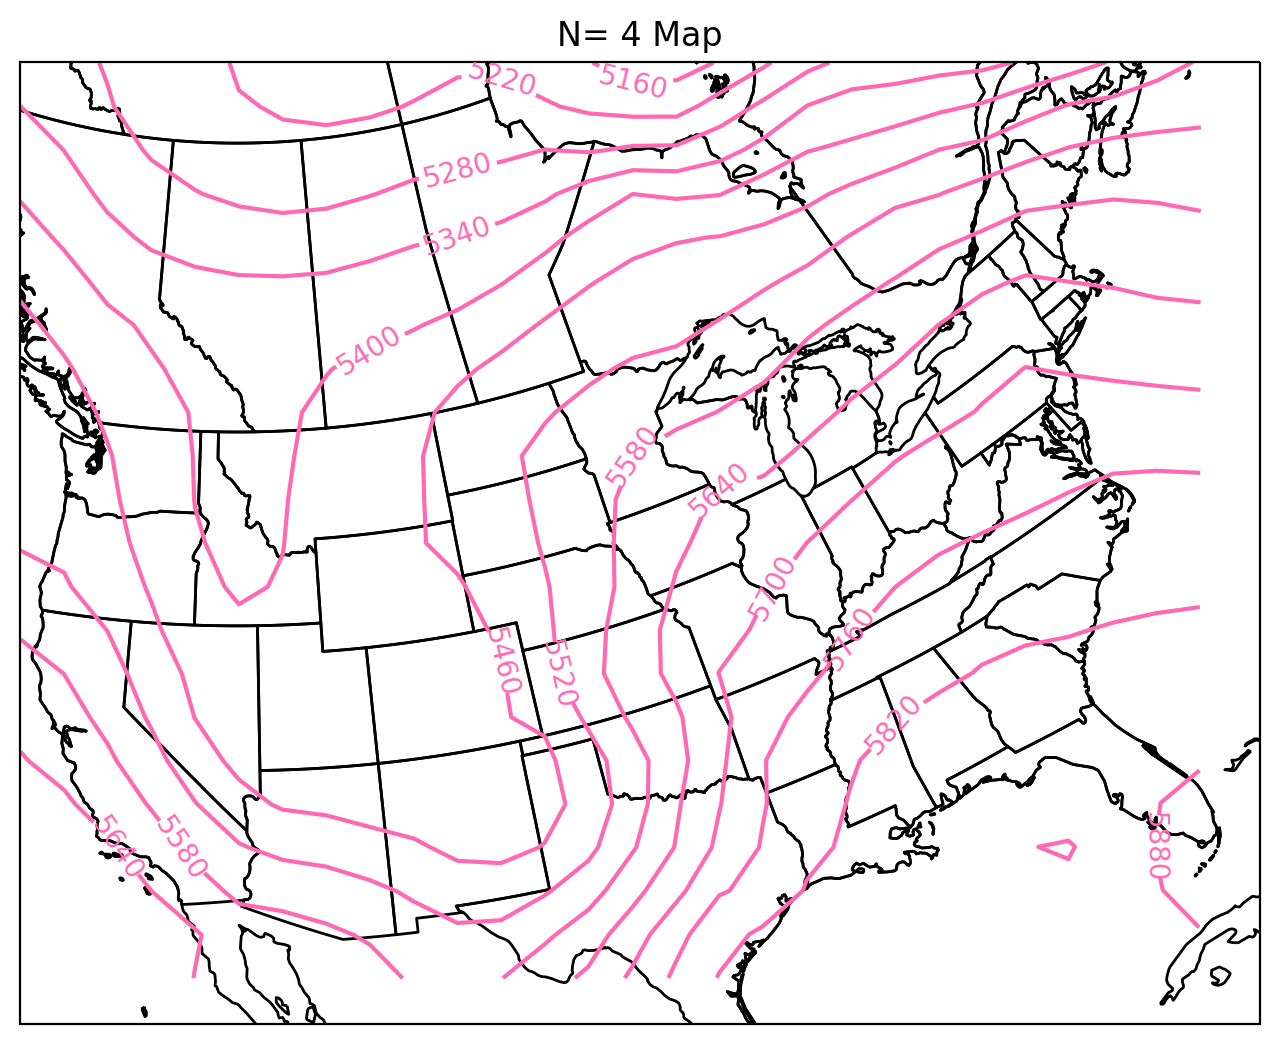

In [60]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

  
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(proj_lon,proj_lat,analysis_matrix[:,:,1],colors='hotpink',levels = np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(0,8000,60))
plt.title("N= 4 Map")
#plt.title("N= 10 Map")
plt.savefig('C://Users/research/thesis_code/ATSC_528_09192022/ATSC528_2022-main/03-Statistical_Objective_Analysis/Map_analysis_N_4.png')

Text(0.5, 1.0, 'N= 10 Map')

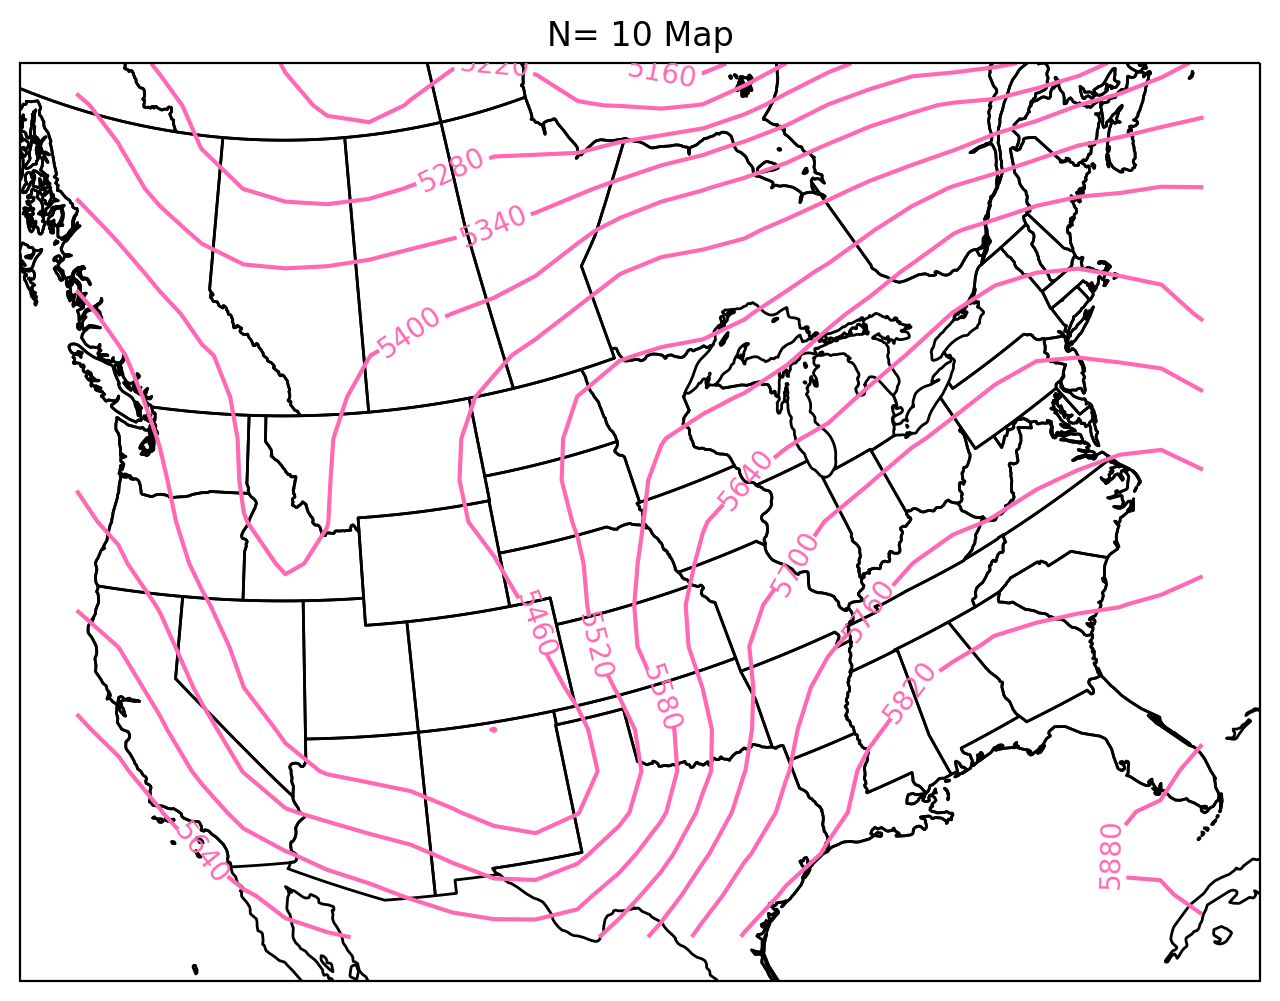

In [61]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

  
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(proj_lon,proj_lat,analysis_matrix[:,:,2],colors='hotpink',levels = np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(0,8000,60))

plt.title("N= 10 Map")
plt.savefig('C://Users/research/thesis_code/ATSC_528_09192022/ATSC528_2022-main/03-Statistical_Objective_Analysis/Map_analysis_N_10.png')

In [71]:
#Solving for Analysis Increment
#Analysis at grid point minus the background at the grid point
#Fa(ri) - Fb(ri)
analysis_increment_N2 = analysis_matrix[:,:,0] -background_matrix[:,:]
analysis_increment_N4 = analysis_matrix[:,:,1] -background_matrix[:,:]
analysis_increment_N10 = analysis_matrix[:,:,2] -background_matrix[:,:]

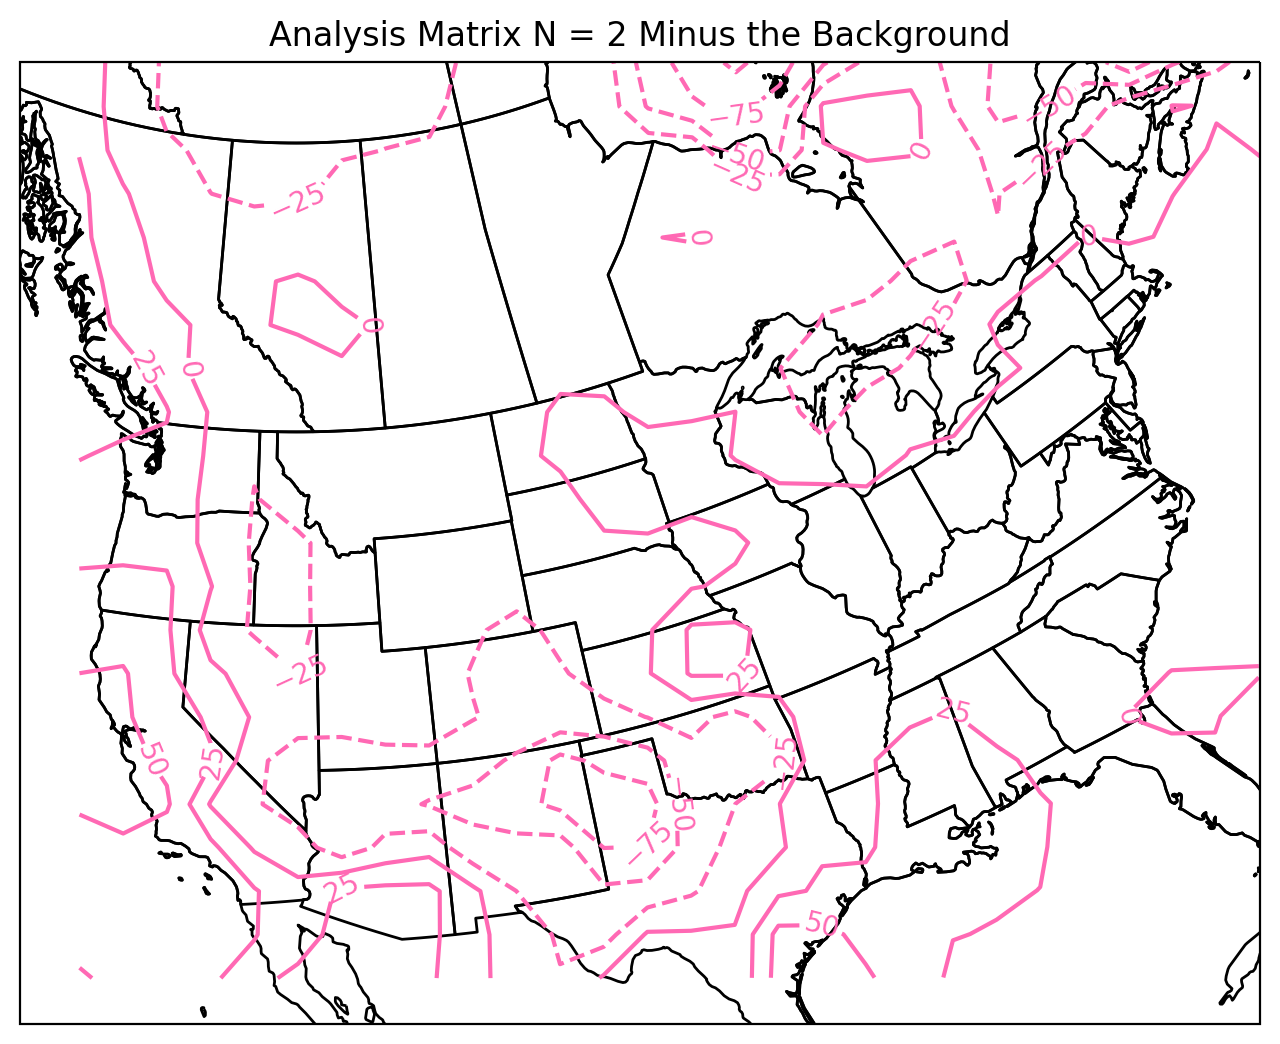

In [72]:
#Analysis Increment with N = 2
#PART C
### Plot 500mb analyses over a map ###

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

  
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(proj_lon,proj_lat,analysis_increment_N2[:,:],colors='hotpink',levels = np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(-8000,8000,25))
plt.title("Analysis Matrix N = 2 Minus the Background")
plt.savefig('C://Users/research/thesis_code/ATSC_528_09192022/ATSC528_2022-main/03-Statistical_Objective_Analysis/Analysis_matrix_N_2.png')

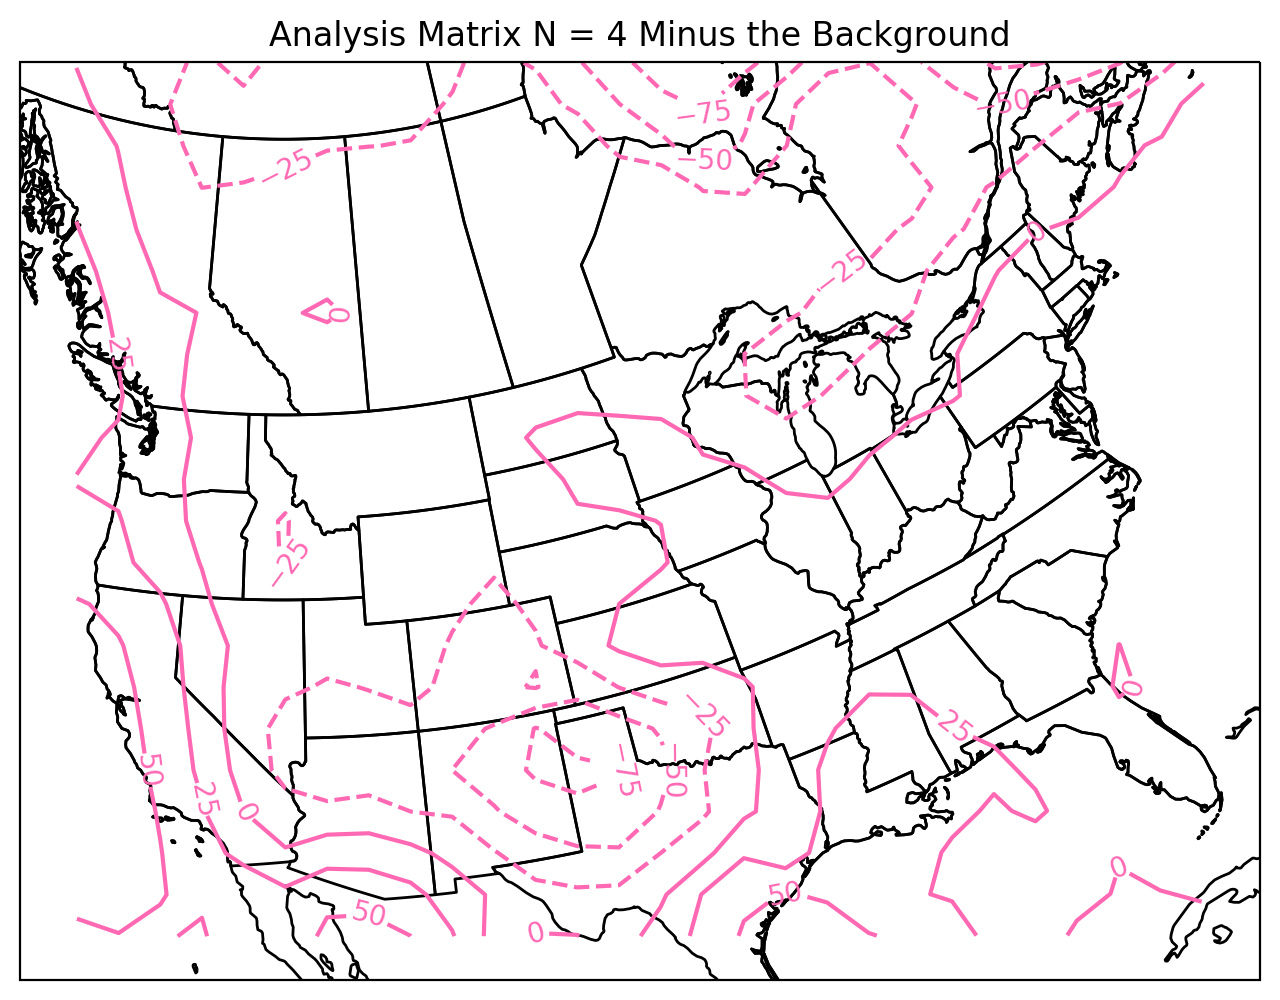

In [73]:
#Analysis Increment with N = 4
#PART C
### Plot 500mb analyses over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

  
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(proj_lon,proj_lat,analysis_increment_N4[:,:],colors='hotpink',levels = np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(-8000,8000,25))
plt.title("Analysis Matrix N = 4 Minus the Background")
plt.savefig('C://Users/research/thesis_code/ATSC_528_09192022/ATSC528_2022-main/03-Statistical_Objective_Analysis/Analysis_matrix_N_4.png')

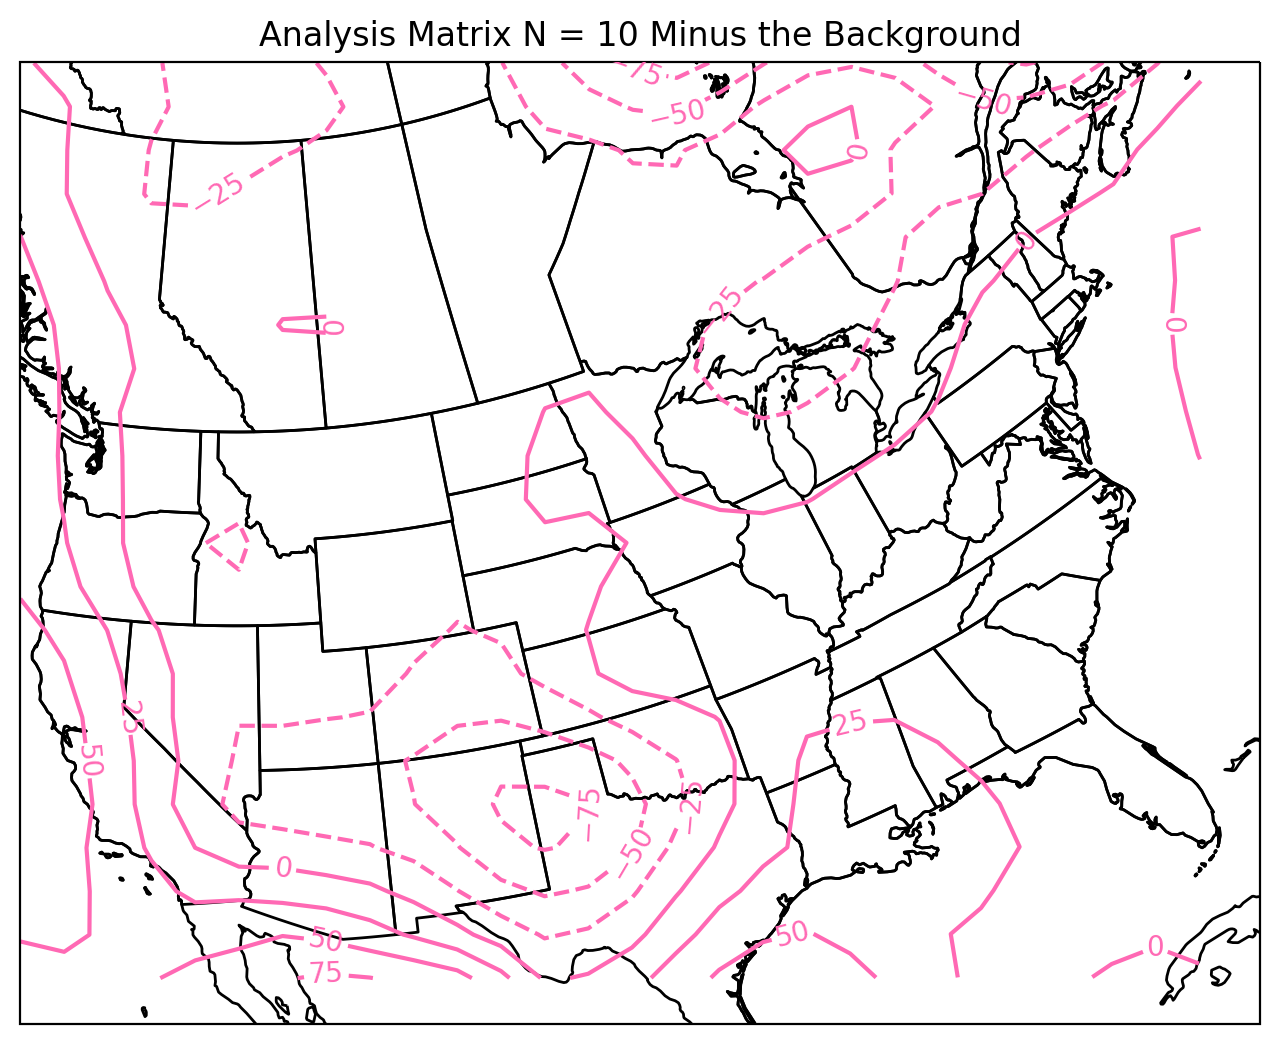

In [74]:
#Analysis Increment with N = 10
#PART C
### Plot 500mb analyses over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

  
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(proj_lon,proj_lat,analysis_increment_N10[:,:],colors='hotpink',levels = np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(-8000,8000,25))
plt.title("Analysis Matrix N = 10 Minus the Background")
plt.savefig('C://Users/research/thesis_code/ATSC_528_09192022/ATSC528_2022-main/03-Statistical_Objective_Analysis/Analysis_matrix_N_10.png')

In [66]:
#Finding the Analysis Difference for N = 2
# the x coord of observations minus the x0 divided by the spacing of the points this will be the same for y
#it is for bilinear
index_x = ((x_obs - x)/delta_x)
index_y = ((y_obs - y)/delta_y)


#finding analysis values at the observation locations. We have the analysis value at the analysis location. 
bilinear_result0 = np.zeros(len(x_obs))
for i in range(len(index_x)):
    if (index_x[i]>= 0) and (index_x[i] < 21) and (index_y[i] >= 0) and (index_y[i] < 27):      #this is the ones that in our grid and we need to use the bilinear here
        p = bilinear2(index_x[i], index_y[i], 0)  #you are using the first index of the analysis matrix 
    else:
        x_dist_analysis = x_obs[i] - grid_x
        y_dist_analysis = y_obs[i] - grid_y
        radius_analysis = ((x_dist_analysis)**2 + (y_dist_analysis)**2)**(1/2)   #this is the distance formula
        vals_analysis = np.where(radius_analysis <= Ro_vals[0])    #is it in our ROI?
        weights_analysis = np.zeros(grid_x.shape)
   
        for j in vals_analysis[0]:  #for the outer points that aren't in the pink star grid. They still have (x,y)
            for k in vals_analysis[1]:
                weights_cressman_analysis = barnes(radius_analysis[j,k], Ro_vals[0])
                weights_analysis[j,k] = weights_cressman_analysis
                #print(weights_analysis)
        p = np.sum(weights_analysis*analysis_matrix[:,:,0])/np.sum(weights_analysis)
    bilinear_result0[i] = p
print(bilinear_result0)

C:\Users\research\AppData\Local\Temp\ipykernel_8436\2321027313.py:25: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(weights_analysis*analysis_matrix[:,:,0])/np.sum(weights_analysis)


[5458.66713969 5537.82531542 5356.01455845 5324.57046757 5225.26935388
 5212.50649811           nan 5285.06287524 5195.20854101 5433.58880137
           nan 5450.94214964 5245.59828255 5370.40881759 5207.06746774
 5483.80343656 5230.7985992  5204.40617513 5286.74452086 5275.99754905
 5305.30308816 5248.66034596 5369.62858082 5453.06896062 5420.73316942
 5385.16618231 5442.32380175 5549.84315118 5344.39508935 5711.16296807
 5337.18610683 5443.85685411 5658.69839307 5465.60887995 5332.68022608
 5394.56707136 5615.07339698 5787.88767204 5330.86144536 5510.58802806
 5817.94505053 5779.09376336 5390.95507599 5798.87329912 5311.68152981
 5666.54272686 5761.67733962 5510.9436786  5333.89980603 5629.96845249
 5812.44328793 5771.17113672 5514.87922601 5463.76520335 5680.98838882
 5569.10581297 5466.48150715 5678.92942707 5666.16900843 5671.02864853
 5532.07538743 5882.97937663 5321.03808354 5821.8375447  5479.1308299
 5639.4095642  5673.65788158 5442.69545493 5427.23485254 5612.9852964
 5777.45

In [67]:
#Finding the Analysis Difference for N = 4
# the x coord of observations minus the x0 divided by the spacing of the points this will be the same for y
#it is for bilinear
index_x = ((x_obs - x)/delta_x)
index_y = ((y_obs - y)/delta_y)


#finding analysis values at the observation locations. We have the analysis value at the analysis location. 
bilinear_result1 = np.zeros(len(x_obs))
for i in range(len(index_x)):
    if (index_x[i]>= 0) and (index_x[i] < 21) and (index_y[i] >= 0) and (index_y[i] < 27):      #this is the ones that in our grid and we need to use the bilinear here
        p = bilinear2(index_x[i], index_y[i], 1)  #you are using the first index of the analysis matrix 
    else:
        x_dist_analysis = x_obs[i] - grid_x
        y_dist_analysis = y_obs[i] - grid_y
        radius_analysis = ((x_dist_analysis)**2 + (y_dist_analysis)**2)**(1/2)   #this is the distance formula
        vals_analysis = np.where(radius_analysis <= Ro_vals[0])    #is it in our ROI?
        weights_analysis = np.zeros(grid_x.shape)
   
        for j in vals_analysis[0]:  #for the outer points that aren't in the pink star grid. They still have (x,y)
            for k in vals_analysis[1]:
                weights_cressman_analysis = barnes(radius_analysis[j,k], Ro_vals[0])
                weights_analysis[j,k] = weights_cressman_analysis
                #print(weights_analysis)
        p = np.sum(weights_analysis*analysis_matrix[:,:,1])/np.sum(weights_analysis)
    bilinear_result1[i] = p
print(bilinear_result1)

C:\Users\research\AppData\Local\Temp\ipykernel_8436\555735689.py:25: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(weights_analysis*analysis_matrix[:,:,1])/np.sum(weights_analysis)


[5458.54757323 5538.23208988 5354.22233928 5313.22925857 5219.94563921
 5210.00463375           nan 5285.53526433 5192.18795246 5431.90255843
           nan 5449.75600813 5240.65994715 5369.74537739 5203.42587691
 5482.44140797 5231.27818878 5195.18639477 5278.56324031 5277.35464561
 5309.88421855 5241.22286788 5363.89359039 5452.5478222  5416.23020552
 5384.71172009 5451.57598949 5546.7999141  5336.97516178 5711.44219086
 5329.1673061  5446.19120418 5659.00280666 5471.14975626 5325.83894541
 5392.49628572 5614.10950507 5791.20481654 5322.14253245 5509.58648486
 5824.38850169 5779.07610577 5393.52092546 5802.14736777 5306.22390196
 5669.86191504 5763.64490963 5501.40848174 5325.2424951  5629.06933746
 5813.46525764 5772.72578844 5512.07618428 5462.08037945 5677.1025547
 5560.93939489 5464.20995011 5674.3169767  5663.45119621 5664.45900358
 5538.24853328 5881.81136004 5315.27997718 5823.54051602 5489.62509238
 5622.54918947 5668.09060414 5442.52540169 5424.53314872 5614.22056208
 5776.6

In [68]:
#Finding the Analysis Difference for N = 10
# the x coord of observations minus the x0 divided by the spacing of the points this will be the same for y
#it is for bilinear
index_x = ((x_obs - x)/delta_x)
index_y = ((y_obs - y)/delta_y)


#finding analysis values at the observation locations. We have the analysis value at the analysis location. 
bilinear_result2 = np.zeros(len(x_obs))
for i in range(len(index_x)):
    if (index_x[i]>= 0) and (index_x[i] < 21) and (index_y[i] >= 0) and (index_y[i] < 27):      #this is the ones that in our grid and we need to use the bilinear here
        p = bilinear2(index_x[i], index_y[i], 2)  #you are using the first index of the analysis matrix 
    else:
        x_dist_analysis = x_obs[i] - grid_x
        y_dist_analysis = y_obs[i] - grid_y
        radius_analysis = ((x_dist_analysis)**2 + (y_dist_analysis)**2)**(1/2)   #this is the distance formula
        vals_analysis = np.where(radius_analysis <= Ro_vals[0])    #is it in our ROI?
        weights_analysis = np.zeros(grid_x.shape)
   
        for j in vals_analysis[0]:  #for the outer points that aren't in the pink star grid. They still have (x,y)
            for k in vals_analysis[1]:
                weights_cressman_analysis = barnes(radius_analysis[j,k], Ro_vals[0])
                weights_analysis[j,k] = weights_cressman_analysis
                #print(weights_analysis)
        p = np.sum(weights_analysis*analysis_matrix[:,:,2])/np.sum(weights_analysis)
    bilinear_result2[i] = p
print(bilinear_result2)

C:\Users\research\AppData\Local\Temp\ipykernel_8436\3528517034.py:25: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(weights_analysis*analysis_matrix[:,:,2])/np.sum(weights_analysis)


[5447.90666733 5538.78719679 5353.61881866 5312.41989544 5227.37089397
 5217.66203609           nan 5288.95466795 5201.06306983 5434.02616456
           nan 5449.29596222 5251.49684157 5369.18214744 5212.9959666
 5484.44381565 5230.49544695 5201.64101441 5284.92352247 5280.65517368
 5310.33610232 5240.82863111 5367.74389151 5452.36096416 5419.35579535
 5385.51170696 5448.48684967 5545.67508257 5341.77493239 5712.32182934
 5334.06767538 5443.8626961  5655.34645452 5471.16790873 5330.76778305
 5393.19073333 5613.07404121 5794.42190115 5326.81419498 5505.20355854
 5825.77898699 5777.86893726 5393.30212488 5803.85665588 5310.05686795
 5667.97128449 5765.77135494 5499.80329869 5330.1362182  5630.79707994
 5811.01715664 5774.18686397 5509.2571675  5461.03843374 5686.61943358
 5561.32145477 5463.02052683 5682.11077973 5662.95457199 5664.02435586
 5547.52002743 5883.74803472 5319.9653644  5824.89273087 5490.81785451
 5622.0411631  5672.29008778 5443.25758305 5422.41209816 5618.47803479
 5777.7

In [69]:
#Compute the root mean square difference between the analyses and observations for each analysis pass.
#fo is the heights and it correlates to the fo in the equation 
difference_1 = (fobs - bilinear_result0)**2
difference_1 = difference_1[~np.isnan(difference_1)]
rms_1 = np.sqrt(np.sum(difference_1/len(difference_1)))
print(rms_1)

difference_2 = (fobs - bilinear_result1)**2
difference_2 = difference_2[~np.isnan(difference_2)]
rms_2 = np.sqrt(np.sum(difference_2/len(difference_2)))
print(rms_2)

difference_3 = (fobs - bilinear_result2)**2
difference_3 = difference_3[~np.isnan(difference_3)]
rms_3 = np.sqrt(np.sum(difference_3/len(difference_3)))
print(rms_3)

rms_vals = list([rms_1,rms_2, rms_3])

51.91923052583784
49.96061067453273
50.97242487632029


In [79]:
### Store the analyses in text files ###
#Saving the matrices as text files.
np.savetxt("N_2_matrix.txt", analysis_matrix[:,:,0], delimiter = ',')
np.savetxt("N_4_matrix.txt", analysis_matrix[:,:,1], delimiter = ',')
np.savetxt("N_10_matrix.txt", analysis_matrix[:,:,2], delimiter = ',')

In [76]:
### Store RMS values in text file ###
np.savetxt("RMS_VALS.txt", rms_vals)

In [80]:
### Store the difference fields in text files ###
np.savetxt("analysis_increment_N2.txt", analysis_increment_N2[:,:], delimiter = ',')
np.savetxt("analysis_increment_N4.txt",analysis_increment_N4[:,:], delimiter = ',')
np.savetxt("analysis_increment_N10.txt", analysis_increment_N10[:,:], delimiter = ',')

In [70]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    A very well defined height gradient exists through Texas. A trough exists through the western half of the United States. Idaho contains a weird triangular contour that dips through a majority of the state.
    A ridge exists through the eastern half of the United States. A dot contour is present in New Mexico. There is a very tight height gradient in Canada. These all describe the SOA of N = 2. The SOA N = 4
    contains a very similar trough and ridge feature. The triangular feature in Idaho is smoothed slightly and the dot in New Mexico. The general ridge and trough shape in the N = 10 plot is observed and it is 
    slightly smoother than the N = 4 and the dot in New Mexico comes back (Guess who's back....Back again... Shady's back....)

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    The N = 10 SOA is the smoothest because it contains more observations meaning the general pattern is more readily detected and the values are not showing the local features as much as the general pattern.
    The smaller scale features are detected more in the N = 2 because there is minimal observations being used so the small scale features have a heavy influence on what is being plotted. The general patterns 
    all SOA schemes is consistent however there are small difference that represent the smaller scale features being highlighted in the analysis or the larger scale features being being highlighted depedning on
    the number of points selected. (They are not that much smoother!) N = 10 is likely the limit in terms of how much ebtter the analysis can get, which is why when we make the N= 50 it closely resemebles the 
    N = 10. 
    

3 - What happens as you increase the number of points considered for the analysis?  Is this 
    desirable?  Why or why not?
    Increasing the number of points in this case casues minimal change in the appearance of the analysis; however, this may not always apply in other cases. A limit is reached in terms of how improved your
    analysis can get meaning that no matter how many points you add the plots will closely resemble each other. There error drops off at a certain point and then remains rather constant. Increasing the points
    from N = 2 to N= 10 caused smoothing, however, N = 10 is likely the limit in terms of improvement so N = 50 or N =100 produces a close looking plot.
'''

"\n1 - Describe the general features that you see in your contoured analyses.\n    A very well defined height gradient exists through Texas. A trough exists through the western half of the United States. Idaho contains a weird triangular contour that dips through a majority of the state.\n    A ridge exists through the eastern half of the United States. A dot contour is present in New Mexico. There is a very tight height gradient in Canada. These all describe the SOA of N = 2. The SOA N = 4\n    contains a very similar trough and ridge feature. The triangular feature in Idaho is smoothed slightly and the dot in New Mexico. The general ridge and trough shape in the N = 10 plot is observed and it is \n    slightly smoother than the N = 4 and the dot in New Mexico comes back (Guess who's back....Back again... Shady's back....)\n\n2 - Describe the differences that you see in your contoured analyses.  \n    Does one analysis seem to be smoother than the other?  If so, what would cause this?